# Modelo Completo de Hidr√≥lise Enzim√°tica - Execu√ß√£o √önica

Esta c√©lula cont√©m o modelo completo de hidr√≥lise enzim√°tica em um √∫nico bloco execut√°vel. Inclui:
- Carregamento e limpeza de dados experimentais do CSV
- Defini√ß√£o de todos os par√¢metros do modelo
- Sistema de equa√ß√µes diferenciais ordin√°rias (ODEs)
- Simula√ß√£o num√©rica
- Plotagem comparativa entre modelo e dados experimentais
- An√°lise de erro quantitativa

Execute esta c√©lula para obter a an√°lise completa.

MODELO DE HIDR√ìLISE ENZIM√ÅTICA - ANGARITA ET AL. 2015

1. CARREGANDO DADOS EXPERIMENTAIS...
‚úì Dados 15%-10FPU carregados: 11 pontos temporais

2. DEFININDO PAR√ÇMETROS DO MODELO...
‚úì Par√¢metros definidos

3. SISTEMA DE ODEs DEFINIDO

4. CONFIGURANDO CONDI√á√ïES INICIAIS...
‚úì Celulose inicial: 99.00 g/L
‚úì Hemicelulose inicial: 12.45 g/L
‚úì Biomassa inicial: 150.00 g/L
‚úì Enzima livre inicial: 0.0198 g/L
‚úì Enzima adsorvida inicial: 0.1552 g/L

5. EXECUTANDO SIMULA√á√ÉO...
‚úì Simula√ß√£o conclu√≠da com sucesso

6. GERANDO GR√ÅFICOS...


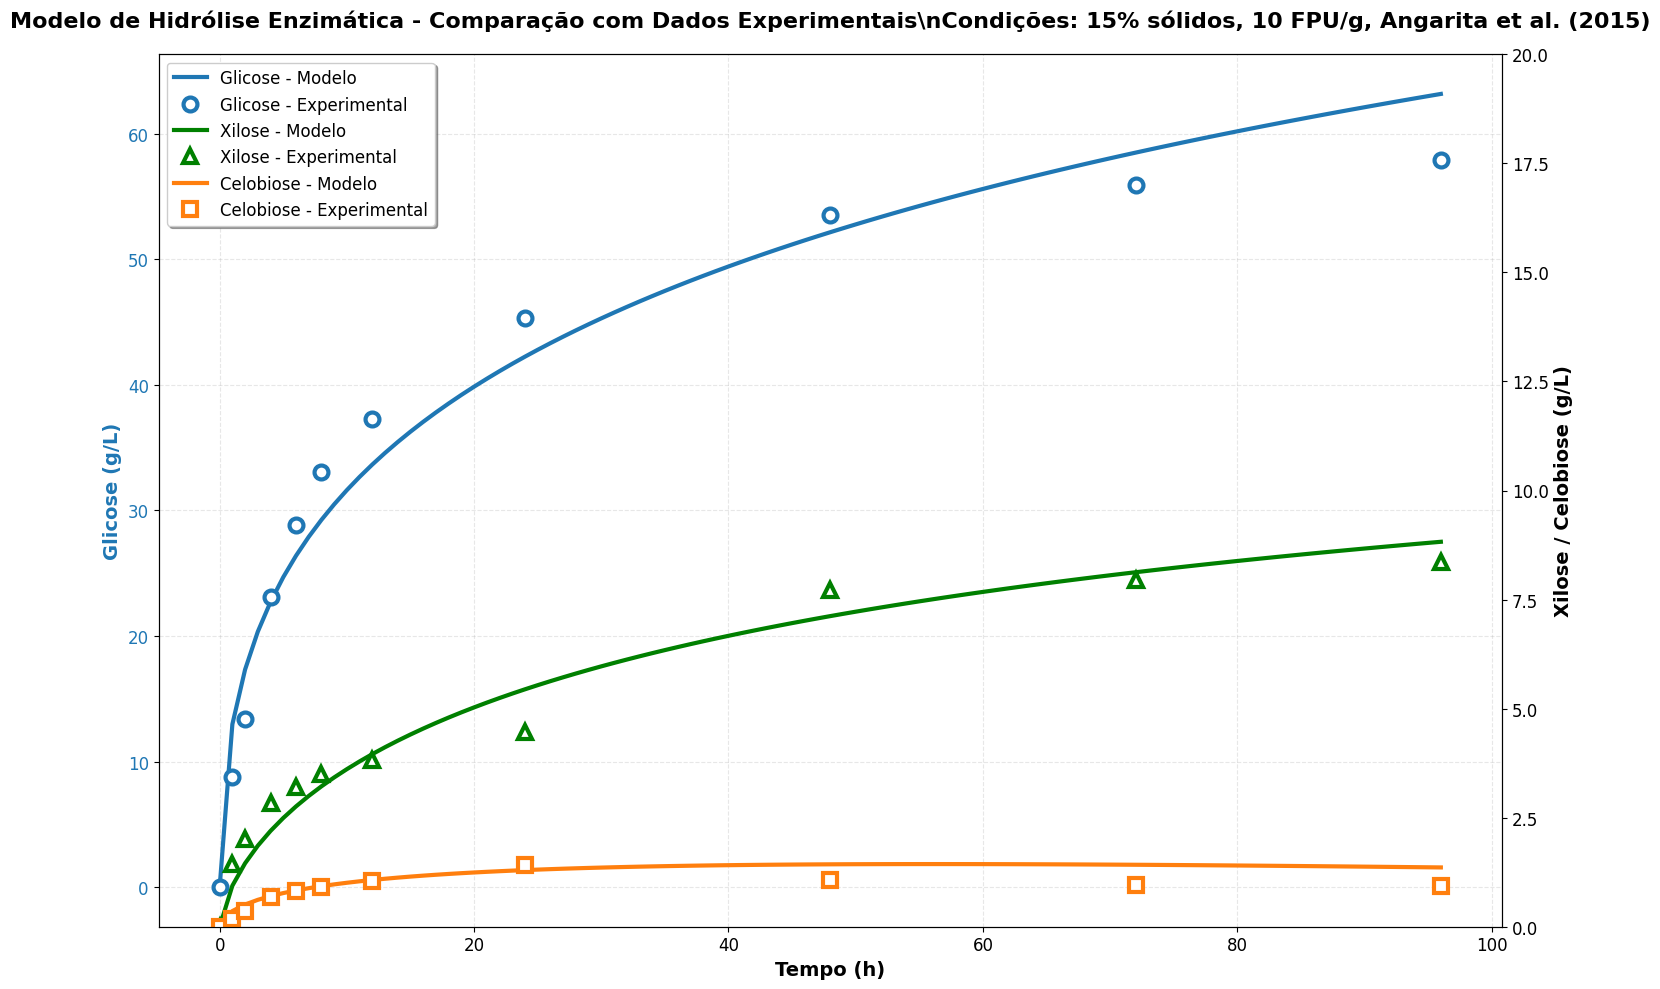


7. AN√ÅLISE QUANTITATIVA DOS RESULTADOS

üìä COMPARA√á√ÉO GLICOSE:
Tempo (h)  Exp (g/L)    Modelo (g/L)   Erro (%)  
--------------------------------------------------
1.0        8.77         12.97          47.8      
2.0        13.36        17.33          29.7      
4.0        23.09        22.71          1.6       
6.0        28.86        26.39          8.6       
8.0        33.10        29.25          11.6      
12.0       37.27        33.66          9.7       
24.0       45.35        42.25          6.8       
48.0       53.56        52.17          2.6       
72.0       55.91        58.50          4.6       
96.0       57.91        63.18          9.1       

üìä COMPARA√á√ÉO XILOSE:
Tempo (h)  Exp (g/L)    Modelo (g/L)   Erro (%)  
--------------------------------------------------
1.0        1.43         0.94           34.3      
2.0        2.01         1.45           27.6      
4.0        2.83         2.20           22.4      
6.0        3.20         2.76           13.8      
8.

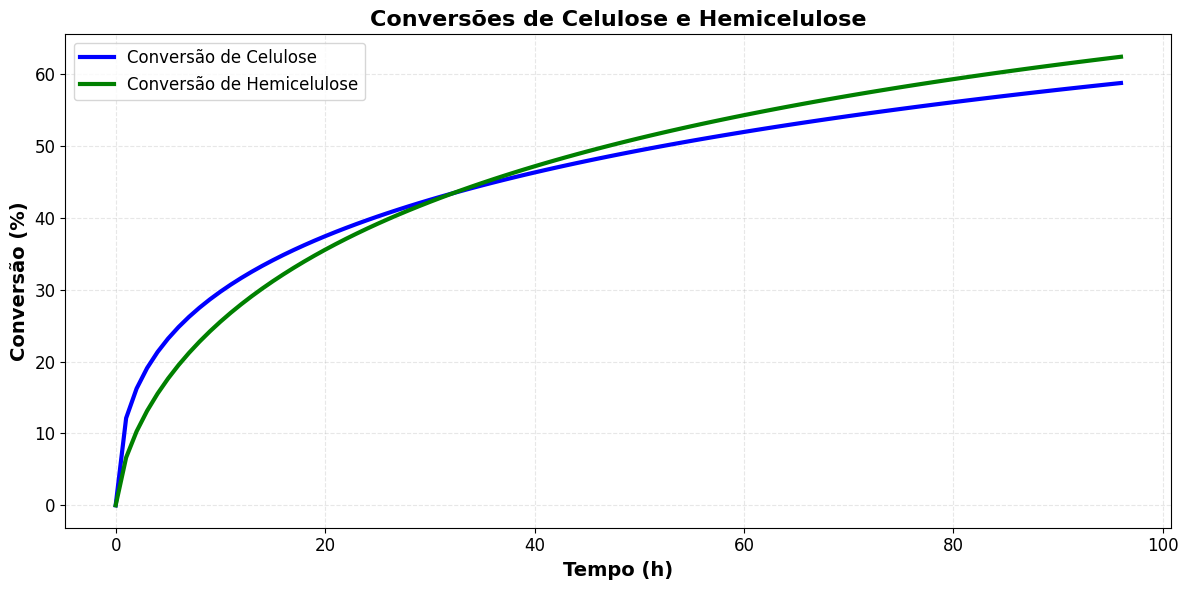


MODELO EXECUTADO COM SUCESSO! ‚úì


In [2]:
# ============================================================================
# MODELO COMPLETO DE HIDR√ìLISE ENZIM√ÅTICA - EXECU√á√ÉO √öNICA
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve

print("=" * 80)
print("MODELO DE HIDR√ìLISE ENZIM√ÅTICA - ANGARITA ET AL. 2015")
print("=" * 80)

# ============================================================================
# 1. CARREGAMENTO DOS DADOS EXPERIMENTAIS DO CSV
# ============================================================================
print("\n1. CARREGANDO DADOS EXPERIMENTAIS...")


df_exp = pd.read_csv('Dados Angarita.csv', sep=',')
df_exp = df_exp.rename(columns=lambda x: x.strip())

# Extrair dados 15%-10FPU (condi√ß√£o do modelo)
tempo_exp = df_exp['Tempo [h]'].values
glicose_exp = pd.to_numeric(df_exp['Glicose [g/L] 15%-10FPU'], errors='coerce').values
xilose_exp = pd.to_numeric(df_exp['Xilose [g/L] 15%-10FPU'], errors='coerce').values
celobiose_exp = pd.to_numeric(df_exp['Celobiose [g/L] 15%-10FPU'], errors='coerce').values

# Limpar dados (remover NaN)
mask_validos = ~np.isnan(glicose_exp) & ~np.isnan(xilose_exp) & ~np.isnan(celobiose_exp) # A vari√°vel mask_validos √© um filtro booleano que identifica quais posi√ß√µes de pontos s√£o v√°lidos (n√£o NaN)
tempo_exp = tempo_exp[mask_validos] # Aplica o filtro para manter apenas os pontos v√°lidos
glicose_exp = glicose_exp[mask_validos]
xilose_exp = xilose_exp[mask_validos]
celobiose_exp = celobiose_exp[mask_validos]

print(f"‚úì Dados 15%-10FPU carregados: {len(tempo_exp)} pontos temporais")

# ============================================================================
# 2. DEFINI√á√ÉO DOS PAR√ÇMETROS DO MODELO
# ============================================================================

print("\n2. DEFININDO PAR√ÇMETROS DO MODELO...")

# Condi√ß√µes operacionais
S0 = 150.0                  # Carregamento de s√≥lidos (g/L)
Cellulose = 0.66           # Fra√ß√£o de celulose
Hemicellulose = 0.083      # Fra√ß√£o de hemicelulose
Lignin = 0.257             # Fra√ß√£o de lignina
E_T = 0.175                # Concentra√ß√£o total de enzima (g/L)
alfa = 1.0                 # Fator de resist√™ncia

# Par√¢metros cin√©ticos (Angarita et al. 2015)
k_1r = 0.177              # Taxa de rea√ß√£o r1 (h‚Åª¬π)
k_2r = 8.81               # Taxa de rea√ß√£o r2 (h‚Åª¬π)
k_3r = 201.0              # Taxa de rea√ß√£o r3 (h‚Åª¬π)
k_4r = 16.34              # Taxa de rea√ß√£o r4 (h‚Åª¬π)

# Constantes de inibi√ß√£o - Rea√ß√£o 1
k_11G2 = 0.402            # Inibi√ß√£o por celobiose (g/L)
k_11G = 2.71              # Inibi√ß√£o por glicose (g/L)
k_11X = 2.15              # Inibi√ß√£o por xilose (g/L)

# Constantes de inibi√ß√£o - Rea√ß√£o 2
k_21G2 = 119.6            # Inibi√ß√£o por celobiose (g/L)
k_21G = 4.69              # Inibi√ß√£o por glicose (g/L)
k_21X = 0.095             # Inibi√ß√£o por xilose (g/L)

# Constantes de Michaelis-Menten - Rea√ß√£o 3
k_3M = 26.6               # Constante de Michaelis (g/L)
k_31G = 11.06             # Inibi√ß√£o por glicose (g/L)
k_31X = 1.023             # Inibi√ß√£o por xilose (g/L)

# Constantes de inibi√ß√£o - Rea√ß√£o 4
k_41G2 = 16.25            # Inibi√ß√£o por celobiose (g/L)
k_41G = 4.0               # Inibi√ß√£o por glicose (g/L)
k_41X = 154.0             # Inibi√ß√£o por xilose (g/L)

# Par√¢metros de adsor√ß√£o enzim√°tica
k_ad = 7.16               # Constante de adsor√ß√£o
E_max = 8.32/1000         # Capacidade m√°xima de adsor√ß√£o (g/L)

print("‚úì Par√¢metros definidos")

# ============================================================================
# 3. FUN√á√ÉO PARA CALCULAR EQUIL√çBRIO ENZIM√ÅTICO
# ============================================================================

def calcular_enzima_equilibrio(E_T, S, E_max, k_ad):
    """Calcula enzima livre e adsorvida em equil√≠brio"""
    def equation(E_F):
        E_B = E_T - E_F
        return E_max * k_ad * E_F / (1 + k_ad * E_F) - E_B / S
    
    E_F = fsolve(equation, 0.1)[0]
    E_B = E_T - E_F
    return E_F, E_B

# ============================================================================
# 4. SISTEMA DE EQUA√á√ïES DIFERENCIAIS
# ============================================================================

def modelo_hidrolise(t, y):
    """
    Sistema de ODEs para hidr√≥lise enzim√°tica
    
    Vari√°veis de estado:
    y[0] = C    - Celulose (g/L)
    y[1] = G2   - Celobiose (g/L)
    y[2] = G    - Glicose (g/L)
    y[3] = H    - Hemicelulose (g/L)
    y[4] = X    - Xilose (g/L)
    y[5] = S    - Biomassa total (g/L)
    y[6] = E_B  - Enzima adsorvida (g/L)
    y[7] = E_F  - Enzima livre (g/L)
    """
    
    C, G2, G, H, X, S, E_B, E_F = y
    
    # Evitar divis√£o por zero
    S = max(S, 1e-6)
    
    # Fator de resist√™ncia
    R_S = alfa * S / S0
    
    # Concentra√ß√µes de enzima espec√≠fica
    Ebc = E_B * C / S     # Enzima espec√≠fica para celulose
    Ebh = E_B * H / S     # Enzima espec√≠fica para hemicelulose
    
    # Taxas de rea√ß√£o
    r1 = k_1r * Ebc * R_S * C / (1 + G2/k_11G2 + G/k_11G + X/k_11X)
    r2 = k_2r * Ebc * R_S * C / (1 + G2/k_21G2 + G/k_21G + X/k_21X)
    r3 = k_3r * E_F * G2 / (k_3M * (1 + G/k_31G + X/k_31X) + G2)
    r4 = k_4r * Ebh * R_S * H / (1 + G2/k_41G2 + G/k_41G + X/k_41X)
    
    # Equa√ß√µes diferenciais
    dCdt = -r1 - r2                 # Celulose
    dG2dt = 1.056 * r1 - r3         # Celobiose
    dGdt = 1.111 * r2 + 1.053 * r3  # Glicose
    dHdt = -r4                      # Hemicelulose
    dXdt = 1.136 * r4               # Xilose
    dSdt = -r1 - r2 - r4            # Biomassa
    
    # Enzimas (equa√ß√µes alg√©bricas - derivadas = 0)
    dE_Bdt = 0
    dE_Fdt = 0
    
    return [dCdt, dG2dt, dGdt, dHdt, dXdt, dSdt, dE_Bdt, dE_Fdt]

print("\n3. SISTEMA DE ODEs DEFINIDO")

# ============================================================================
# 5. CONDI√á√ïES INICIAIS E SIMULA√á√ÉO
# ============================================================================
print("\n4. CONFIGURANDO CONDI√á√ïES INICIAIS...")

# Calcular enzimas em equil√≠brio inicial
E_F_inicial, E_B_inicial = calcular_enzima_equilibrio(E_T, S0, E_max, k_ad)

# Condi√ß√µes iniciais
y0 = [
    S0 * Cellulose,      # Celulose inicial
    0.0,                 # Celobiose inicial
    0.0,                 # Glicose inicial
    S0 * Hemicellulose,  # Hemicelulose inicial
    0.0,                 # Xilose inicial
    S0,                  # Biomassa inicial
    E_B_inicial,         # Enzima adsorvida inicial
    E_F_inicial          # Enzima livre inicial
]

print(f"‚úì Celulose inicial: {y0[0]:.2f} g/L")
print(f"‚úì Hemicelulose inicial: {y0[3]:.2f} g/L")
print(f"‚úì Biomassa inicial: {y0[5]:.2f} g/L")
print(f"‚úì Enzima livre inicial: {y0[7]:.4f} g/L")
print(f"‚úì Enzima adsorvida inicial: {y0[6]:.4f} g/L")

# Configura√ß√£o da simula√ß√£o
t_final = 96.0
t_pontos = np.linspace(0, t_final, 97)

print("\n5. EXECUTANDO SIMULA√á√ÉO...")

# Resolver sistema de ODEs
sol = solve_ivp(modelo_hidrolise, [0, t_final], y0, t_eval=t_pontos, method='LSODA', rtol=1e-8)

if sol.success:
    print("‚úì Simula√ß√£o conclu√≠da com sucesso")
    
    # Extrair resultados
    t_sim = sol.t
    C_sim = sol.y[0]     # Celulose
    G2_sim = sol.y[1]    # Celobiose
    G_sim = sol.y[2]     # Glicose
    H_sim = sol.y[3]     # Hemicelulose
    X_sim = sol.y[4]     # Xilose
    S_sim = sol.y[5]     # Biomassa
    EB_sim = sol.y[6]    # Enzima adsorvida
    EF_sim = sol.y[7]    # Enzima livre
    
else:
    print("‚úó Erro na simula√ß√£o:", sol.message)

# ============================================================================
# 6. PLOTAGEM DOS RESULTADOS
# ============================================================================
print("\n6. GERANDO GR√ÅFICOS...")

# Criar figura principal
fig, ax1 = plt.subplots(figsize=(15, 10))

# Glicose no eixo esquerdo
ax1.plot(t_sim, G_sim, '-', label='Glicose - Modelo', color='tab:blue', linewidth=3)
ax1.plot(tempo_exp, glicose_exp, 'o', label='Glicose - Experimental', 
         color='tab:blue', markersize=10, markerfacecolor='white', 
         markeredgewidth=3, markeredgecolor='tab:blue')

ax1.set_xlabel('Tempo (h)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Glicose (g/L)', color='tab:blue', fontsize=14, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=12)
ax1.tick_params(axis='x', labelsize=12)
ax1.grid(True, alpha=0.3, linestyle='--')

# Xilose e Celobiose no eixo direito
ax2 = ax1.twinx()

ax2.plot(t_sim, X_sim, '-', label='Xilose - Modelo', color='green', linewidth=3)
ax2.plot(tempo_exp, xilose_exp, '^', label='Xilose - Experimental', 
         color='green', markersize=10, markerfacecolor='white', 
         markeredgewidth=3, markeredgecolor='green')

ax2.plot(t_sim, G2_sim, '-', label='Celobiose - Modelo', color='tab:orange', linewidth=3)
ax2.plot(tempo_exp, celobiose_exp, 's', label='Celobiose - Experimental', 
         color='tab:orange', markersize=10, markerfacecolor='white', 
         markeredgewidth=3, markeredgecolor='tab:orange')

ax2.set_ylabel('Xilose / Celobiose (g/L)', color='black', fontsize=14, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='black', labelsize=12)
ax2.set_ylim(0, 20)

# Legendas combinadas
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', 
           fontsize=12, frameon=True, fancybox=True, shadow=True)

plt.title('Modelo de Hidr√≥lise Enzim√°tica - Compara√ß√£o com Dados Experimentais\\n' +
          'Condi√ß√µes: 15% s√≥lidos, 10 FPU/g, Angarita et al. (2015)', 
          fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# ============================================================================
# 7. AN√ÅLISE QUANTITATIVA
# ============================================================================
print("\n7. AN√ÅLISE QUANTITATIVA DOS RESULTADOS")
print("=" * 60)

# Interpolar modelo nos tempos experimentais
G_modelo_interp = np.interp(tempo_exp, t_sim, G_sim)
X_modelo_interp = np.interp(tempo_exp, t_sim, X_sim)
G2_modelo_interp = np.interp(tempo_exp, t_sim, G2_sim)

# Tabela de compara√ß√£o - Glicose
print("\nüìä COMPARA√á√ÉO GLICOSE:")
print(f"{'Tempo (h)':<10} {'Exp (g/L)':<12} {'Modelo (g/L)':<14} {'Erro (%)':<10}")
print("-" * 50)
erros_G = []
for i in range(len(tempo_exp)):
    if glicose_exp[i] > 0:
        erro = abs(G_modelo_interp[i] - glicose_exp[i]) / glicose_exp[i] * 100
        erros_G.append(erro)
        print(f"{tempo_exp[i]:<10.1f} {glicose_exp[i]:<12.2f} {G_modelo_interp[i]:<14.2f} {erro:<10.1f}")

# Tabela de compara√ß√£o - Xilose
print("\nüìä COMPARA√á√ÉO XILOSE:")
print(f"{'Tempo (h)':<10} {'Exp (g/L)':<12} {'Modelo (g/L)':<14} {'Erro (%)':<10}")
print("-" * 50)
erros_X = []
for i in range(len(tempo_exp)):
    if xilose_exp[i] > 0:
        erro = abs(X_modelo_interp[i] - xilose_exp[i]) / xilose_exp[i] * 100
        erros_X.append(erro)
        print(f"{tempo_exp[i]:<10.1f} {xilose_exp[i]:<12.2f} {X_modelo_interp[i]:<14.2f} {erro:<10.1f}")

# Estat√≠sticas finais
print("\nüìà ESTAT√çSTICAS DO MODELO:")
print(f"Erro m√©dio absoluto - Glicose: {np.mean(erros_G):.1f}%")
print(f"Erro m√©dio absoluto - Xilose: {np.mean(erros_X):.1f}%")
print(f"Convers√£o final de celulose: {(1 - C_sim[-1]/(S0*Cellulose))*100:.1f}%")
print(f"Convers√£o final de hemicelulose: {(1 - H_sim[-1]/(S0*Hemicellulose))*100:.1f}%")
print(f"Concentra√ß√£o final de glicose: {G_sim[-1]:.2f} g/L")
print(f"Concentra√ß√£o final de xilose: {X_sim[-1]:.2f} g/L")

# ============================================================================
# 8. GR√ÅFICO ADICIONAL - CONVERS√ïES
# ============================================================================

# Gr√°fico de convers√µes
plt.figure(figsize=(12, 6))

conv_celulose = (1 - C_sim / (S0 * Cellulose)) * 100
conv_hemicelulose = (1 - H_sim / (S0 * Hemicellulose)) * 100

plt.plot(t_sim, conv_celulose, 'b-', linewidth=3, label='Convers√£o de Celulose')
plt.plot(t_sim, conv_hemicelulose, 'g-', linewidth=3, label='Convers√£o de Hemicelulose')

plt.xlabel('Tempo (h)', fontsize=14, fontweight='bold')
plt.ylabel('Convers√£o (%)', fontsize=14, fontweight='bold')
plt.title('Convers√µes de Celulose e Hemicelulose', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("MODELO EXECUTADO COM SUCESSO! ‚úì")
print("=" * 80)